### Assigment II: Random Forest

### Step 1:
Load the training data in pandas, check for missing values and apply relevent diagnostics.

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [36]:
data = pd.read_csv('/Users/david/Downloads/titanicdata/titanic.csv', sep = '\t', index_col= 'PassengerId')

In [37]:
# Filling missing Age values with mean
data['Age'] = data['Age'].fillna(data['Age'].mean())

In [38]:
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])
#already binary, no need for one hot encoding

In [39]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


### Step 2: One hot encoding
When dealing with categforical data, it is important to convert them to a form of numerical representations so the computer systems can understand them better.

In [40]:
data['Embarked'] = data['Embarked'].fillna('N')
ports = {"S": 0, "C": 1, "Q": 2, "N": 3}
data['Embarked'] = data['Embarked'].map(ports)
# had some issues with the OneHotEncoder, but this is a sufficient workaround

In [41]:
data = data.drop(columns = ['Name', 'Ticket', 'Cabin'])

In [42]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0
2,1,1,0,38.0,1,0,71.2833,1
3,1,3,0,26.0,0,0,7.9250,0
4,1,1,0,35.0,1,0,53.1000,0
5,0,3,1,35.0,0,0,8.0500,0


In [94]:
data.isnull().sum().sort_values(ascending=False)

Embarked    0
Fare        0
Parch       0
SibSp       0
Age         0
Sex         0
Pclass      0
dtype: int64

In [43]:
# Although there may be some useful information that can be parsed out from Cabin and Name,
# it requires some understanding of the ship's design and what names suggest about social standing, respectively.
# For the time being, I'll encode Sex (likely a primary determinant) and Embarked (probably irrelevent).

### Step 3: Baseline model
Train a Random-Forest Classifier on your data. Whats the AUC value for your model? Plot the ROC Curve and interpret your results!

In [44]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [45]:
labels = data['Survived']
data = data.drop('Survived', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [47]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6908212560386473

Text(0.5,0,'False Positives')

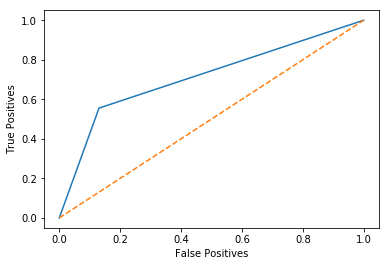

In [101]:
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positives')
plt.xlabel('False Positives')

### Step 4: Number of Estimators
n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore lets do a parameter search to find the sweet spot. Calculate the AUC score for different number of trees.

In [48]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)


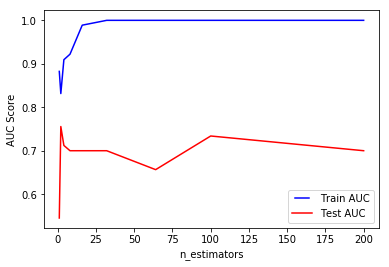

In [49]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label = 'Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label = 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('n_estimators')
plt.show()

### Step 5: Tuning max_depth
max_depth represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. visualize the effect of max_depth for test and train set data AUC scores. What are your findings?



In [50]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

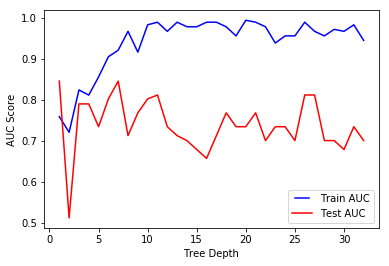

In [51]:
line1, = plt.plot(max_depths, train_results, 'b', label = 'Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label = 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.show()

### STEP 6: min_samples _split
min_samples _split represents the minimum number of samples required to split an internal node.
This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, each tree in the forest becomes more constrained as it has to consider more samples at each node. Lets try and experiment with different values of this parameter from 10% to 100%.

In [52]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

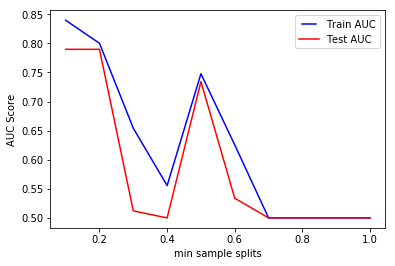

In [53]:
line1, = plt.plot(min_samples_splits, train_results, 'b', label = 'Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label = 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('min sample splits')
plt.show()

### STEP 7: min__samples _leaf
min_samples_leaf is The minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs, the base of the tree. We will continue experimenting different values using below calculation:

In [54]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

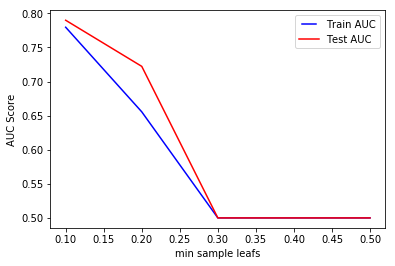

In [55]:
line1, = plt.plot(min_samples_leafs, train_results, 'b', label = 'Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label = 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('min sample leafs')
plt.show()

### STEP 8: max_features
max_features represents the number of features to consider when looking for the best split. Lets experiment different values using below line of code:

In [56]:
max_features = list(range(1,data.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   rf = RandomForestClassifier(max_features=max_feature)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

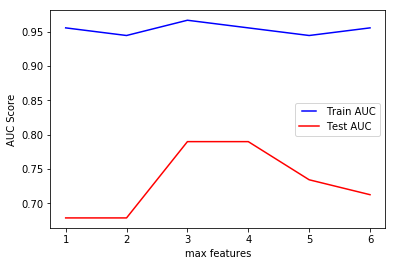

In [57]:
line1, = plt.plot(max_features, train_results, 'b', label = 'Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label = 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('max features')
plt.show()

### STEP 9: Putting ALL together!!!
Using a searching mechanism find the optimal parameters in one block of code! Do the optimal values for each of the above steps match to your findings?

In [25]:
from sklearn.grid_search import GridSearchCV

/Users/david/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/david/anaconda3/lib/python3.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [90]:
parameters = {
    'n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200],
    'max_depth' : [1,5,10,15,20,25,30,32],
    'min_samples_split' : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'min_samples_leaf' : [0.1, 0.2, 0.3, 0.4, 0.5],
    'max_features' : [1, 2, 3, 4, 5, 6, 7]
}

In [91]:
rf = RandomForestClassifier()
grid = GridSearchCV(estimator = rf, param_grid = parameters)

In [92]:
grid.fit(x_train, y_train)
print(grid)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200], 'max_depth': [1, 5, 10, 15, 20, 25, 30, 32], 'min_samples_split': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0], 'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_features': [1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)


In [93]:
grid.best_params_
# that took a while!

{'max_depth': 1,
 'max_features': 5,
 'min_samples_leaf': 0.2,
 'min_samples_split': 0.5,
 'n_estimators': 16}

The best parameters, as determined manually and feature by feature, differ considerably from those determined with gridsearch. Obviously, each parameter is contingent on the other paramaters.

Retrospectively, it would be better to determine hyperparamter ranges with random testing and fine-tune with gridsearch.

Finally, it should be noted that these are unexceptional results. A quick look at the Kaggle leaderboard will show that feature engineering is the key to improving classification accuracy. However, that is not the purpose of this assignment.